# Imports

In [1]:
import os
import torch
import numpy as np
import torch
from torch.autograd import Function
import torch
import torch.nn.functional as F
import torch.nn as nn

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch_geometric
from torch_geometric.datasets import StochasticBlockModelDataset
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader, NodeLoader
import networkx as nx

# Utilities

## models

In [35]:
# torch.manual_seed(1234567)


class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None



class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes, dann_lambda = 0.5):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
        self.domain_classifier = GCNConv(hidden_channels, 2)
        self.dann_lambda = dann_lambda

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        y_class = self.conv2(x, edge_index)

        reverse_feature = ReverseLayerF.apply(x, self.dann_lambda)
        y_domain = self.domain_classifier(reverse_feature, edge_index)

        return y_class, y_domain


from torch_geometric.nn import GATv2Conv

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8, dann_lambda = 0.5):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.domain_classifier = GATv2Conv(dim_h*heads, 2, heads=1)
        self.dann_lambda = dann_lambda


    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        y_class = self.gat2(h, edge_index)

        reverse_feature = ReverseLayerF.apply(h, self.dann_lambda)
        y_domain = self.domain_classifier(reverse_feature, edge_index)

        return y_class, y_domain





def create_model(model_args):
  # model declaration

  match model_args['model_type']:
    case 'GCN':
      model = GCN(**model_args['model_hyperparams'])

    case 'GAT':
      model = GAT(**model_args['model_hyperparams'])

    case other:
      print('model type is non-default!')

  return model

## datasets

In [28]:
class TransferDatasetExperiment():
  def __init__(self, description, data_args):

    possible_experiments = ['sbm']

    if description in possible_experiments:
      self.description = description

    else:
      print('non default dataset experiment')
      return

    self.src_data = None
    self.tgt_data = None
    self.data_args = None

    self.create_dataloaders()


  def create_dataloaders(self):
    match self.description:
      case 'sbm':
        src_data, tgt_data = create_transfer_symmetric_sbm_datasets(**data_args)

      case other:
        print('non default dataset experiment')
        return

    self.src_data = src_data
    self.tgt_data = tgt_data

  def get_dataloaders(self):
    return self.src_data, self.tgt_data




# creates diagonal probabilities for the sbm model. p/q are intra/inter class probability
def create_symmetric_block_probs(n_blocks, p, q):
  probs = []
  for i in range(n_blocks):
    block_probs = q*np.ones(n_blocks)
    block_probs[i] = p
    probs.append(block_probs.tolist())

  return probs





# creates an sbm symmetric dataset using pytorch geometric and returns nodes and edges
def create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root='.'):
  block_sizes = [block_size]*n_blocks
  block_probs = create_symmetric_block_probs(n_blocks, intra_block_prob, inter_block_prob)
  dataset = StochasticBlockModelDataset(root=root , block_sizes = block_sizes, edge_probs = block_probs,
                                          num_channels = n_node_features)
  return dataset[0]




# creates dataloaders for target and source
def create_sbm_symmetric_transfer_dataloaders(dataset_s, dataset_t):
  x_src = dataset_s.x
  x_tgt = dataset_t.x

  edge_src = dataset_s.edge_index
  edge_tgt = dataset_t.edge_index

  #same features
  # x_src = torch.Tensor(np.ones_like(x_src))
  # x_tgt = torch.Tensor(np.ones_like(x_tgt))

  y_src = dataset_s.y
  y_tgt = dataset_t.y


  dataset_src = Data(x=x_src, edge_index = edge_src)
  dataset_tgt = Data(x=x_tgt, edge_index = edge_tgt)
  dataset_src.y = y_src
  dataset_tgt.y = y_tgt


  return dataset_src, dataset_tgt



# high-level transfer experiments with symmetric sbm datasets
def create_transfer_symmetric_sbm_datasets(root = '.', block_size = 300, n_blocks = 5, n_node_features = 100, source_probs = [0.8, 0.1], target_probs = [0.1, 0.8]):
  # source dataset
  intra_block_prob = source_probs[0]
  inter_block_prob = source_probs[1]
  dataset_s = create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root = root + '/src')


  # target dataset
  intra_block_prob = target_probs[0]
  inter_block_prob = target_probs[1]
  dataset_t = create_sbm_symmetric_dataset(block_size, n_blocks, intra_block_prob, inter_block_prob, n_node_features, root = root + '/tgt')

  return create_sbm_symmetric_transfer_dataloaders(dataset_s, dataset_t)



def create_prob_sweep(p, q, step_size, n_steps):
    probs = []
    if p - step_size*n_steps < 0 or q + step_size*n_steps > 1:
        print('conditions (p - step_size*n_count < 0) and (q + step_size*n_count) are not met!')
        return

    for i in range(n_steps + 1):
        probs.append([p - step_size*i, q + step_size*i])

    return probs



def create_description_from_probs(source_probs=[0.1, 0.1], target_probs=[0.1, 0.1]):
  source_description = f'source : p,q = ({source_probs[0]:.3f}, {source_probs[1]:.3f})'
  target_description = f'target : p,q = ({target_probs[0]:.3f}, {target_probs[1]:.3f})'

  return source_description + '_' + target_description

## train

In [5]:
#simple training loop. returns losses
class Trainer():
  def __init__(self, device, model, data_src, data_tgt, optimizer, criterion, transfer = True, transfer_type = 'dann', log_epochs = True):

    self.device = device
    self.model = model
    self.data_src = data_src
    self.data_tgt = data_tgt
    self.optimizer = optimizer
    self.criterion = criterion

    self.transfer = transfer
    self.transfer_type = transfer_type
    self.log_epochs = log_epochs

    losses = dict()
    losses['source'] = []
    losses['source_accs'] = []

    if transfer:
      losses['target'] = []
      losses['target_accs'] = []

      if transfer_type == 'dann':
        losses['discriminator'] = []

    losses['total'] = []

    self.losses = losses






  def train(self, epochs = 5, store_tgt_accs = True, store_src_accs = True):
    # data_src = NodeLoader(data_src, batch_size = 100, shuffle = False)
    # data_tgt = NodeLoader(data_tgt, batch_size = 100, shuffle = False)


    if self.log_epochs == True:

      print('Training!')
      from tqdm import tqdm
      epochs_iterable = tqdm(range(epochs))

    else: epochs_iterable = range(epochs)




    for epoch in epochs_iterable:

        self.model.train()
        self.optimizer.zero_grad()

        #forward
        cls_src_preds, domain_src_preds = self.model(self.data_src.x, self.data_src.edge_index)

        if self.transfer:
          cls_tgt_preds, domain_tgt_preds = self.model(self.data_tgt.x, self.data_tgt.edge_index)

        # source classification loss
        src_cls_loss = self.criterion(cls_src_preds, self.data_src.y)


        # transfer learning experiment
        if self.transfer:
          #adversarial discriminator loss
          if self.transfer_type == 'dann':
            domain_dsc_src_loss = self.criterion(domain_src_preds, torch.ones_like(domain_src_preds).to(self.device))
            domain_dsc_tgt_loss = self.criterion(domain_tgt_preds, torch.zeros_like(domain_tgt_preds).to(self.device))
            discriminator_loss = domain_dsc_src_loss/2

          total_loss = discriminator_loss + src_cls_loss


        #optimizer step
        total_loss.backward()
        self.optimizer.step()




        self.model.eval()

        #store losses
        self.losses['source'].append(src_cls_loss.detach().cpu().numpy())
        self.losses['total'].append(total_loss.detach().cpu().numpy())

        if store_tgt_accs:
          self.losses['target_accs'].append(eval_cls_preds(cls_tgt_preds, self.data_tgt.y))

        if store_src_accs:
          self.losses['source_accs'].append(eval_cls_preds(cls_src_preds, self.data_src.y))


        if self.transfer:
          eval_loss = self.criterion(cls_tgt_preds, self.data_tgt.y)
          self.losses['target'].append(eval_loss.detach().cpu().numpy())

          if self.transfer_type == 'dann':
            self.losses['discriminator'].append(discriminator_loss.detach().cpu().numpy())





    if self.log_epochs == True: print('\nDone')




## evaluations

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = 'darkgrid')


def plot_results_dict(results, title = ".", legends = [], plot_args = dict()):
  import matplotlib.pyplot as plt
  import seaborn as sns
  sns.set_theme()

  plt.title(title)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  keys = results.keys()
  for key in keys:
    plt.plot(results[key], **plot_args)

  plt.legend(legends)


def plot_struct_sweep_histogram(results, experiments_iterator):
  x, y, z = create_mesh_from_results(results, experiments = experiments, key = 'max_target_accs', aggregator = np.mean)

  plt.subplot(1,2,1)
  plt.scatter(x, y, c=z, cmap = 'magma', s=100)
  plt.title('Target Accuracies')
  plt.colorbar()

  xlim = x.min() - 0.1, x.max() + 0.1
  ylim = y.min() - 0.1, y.max() + 0.1

  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.xlabel('Source Hemophility')
  plt.ylabel('Target Hemophility')

  x, y, z_std = create_mesh_from_results(results, experiments = experiments, key = 'max_target_accs', aggregator = np.std)


  plt.subplot(1,2,2)
  plt.scatter(x, y, c=z_std, cmap = 'magma', s = 100)
  plt.title('Target Accuracies (STD)')
  plt.colorbar()

  xlim = x.min() - 0.1, x.max() + 0.1
  ylim = y.min() - 0.1, y.max() + 0.1

  plt.xlim(xlim)
  plt.ylim(ylim)
  plt.xlabel('Source Hemophility')
  plt.ylabel('Target Hemophility')


def create_mesh_from_results(results, experiments, key = '', aggregator = np.mean):
  x, y, z = [], [], []

  for experiment in experiments:
    x.append(experiment[0][0])
    y.append(experiment[1][0])

    description = create_description_from_probs(experiment[0], experiment[1])
    z.append(aggregator(results[description][key]))

  return np.array(x), np.array(y), np.array(z)



# find accuracy from model outputs
def eval_cls_preds(cls_preds, y_true):
  preds = cls_preds.argmax(dim=1)

  num_samples = preds.shape[0]
  correct = int((preds == y_true).sum())
  acc = correct / num_samples

  return acc



# evaluate model accuracy
def eval_model_acc(model, data):
  model.eval()
  cls_preds, _ = model(data.x, data.edge_index)
  return eval_cls_preds(cls_preds, data.y)



def get_results(runs_losses, get_max_tgt_accs = True, get_max_src_accs = True):

  # find average losses
  results = dict()
  results['average_losses'] = average_dicts_of_number_lists(runs_losses)

  # find index of minimum target accuracy
  if get_max_tgt_accs:
    # get best accuracies at each run in an array
    results['max_target_accs'] = get_mapped_array_from_dicts(runs_losses, key = 'target_accs', map = np.max)

  if get_max_src_accs:
    results['max_source_accs'] = get_mapped_array_from_dicts(runs_losses, key = 'source_accs', map = np.max)

  return results


# find average dictionary of a set of dictionaries of scalar lists
def average_dicts_of_number_lists(list_of_dicts = []):

  n_dicts = len(list_of_dicts)
  sample_dict = list_of_dicts[0]
  keys = sample_dict.keys()

  average_dict = dict()

  for key in keys:
    average_dict[key] = np.zeros_like(np.array(sample_dict[key]))

  for dict_idx in range(n_dicts):
    curr_dict = list_of_dicts[dict_idx]

    for key in keys:
      average_dict[key] += np.array(curr_dict[key])/n_dicts

  return average_dict


# apply function to a certain key of a list of dicts
def get_mapped_array_from_dicts(list_of_dicts = [], key = 'source_accs', map = np.max):
  n_dicts = len(list_of_dicts)
  array = []

  for dict_idx in range(n_dicts):
    curr_dict = list_of_dicts[dict_idx]
    array.append(map(curr_dict[key]))

  return np.array(array)



def store_results(results = dict(), descriptions = [], root = './', experiments_name = ''):

  if root.endswith('/'):
    descriptions_path = root + experiments_name + '_' + 'experiments_descriptions.txt'

  else:
    descriptions_path = root + '/' + experiments_name + '_' + 'experiments_descriptions.txt'

  for description in descriptions:

    description_string = experiments_name + '_' + description

    if root.endswith('/'):
      path = root + description_string

    else:
      path = root + '/' + description_string

    # store average losses
    average_losses_root = path + '_' + 'average_losses'
    average_loss_dict = results[description]['average_losses']

    for key in average_loss_dict.keys():
      average_loss_path = average_losses_root + '_' + key
      np.save(average_loss_path, arr = average_loss_dict[key])

    # store max accuracy arrays
    if 'source_accs' in results[description].keys():
      source_accs_root = path + '_' + 'source_accs'
      np.save(source_accs_root, results[description]['source_accs'])

    if 'target_accs' in results[description].keys():
      target_accs_root = path + '_' + 'target_accs'
      np.save(target_accs_root, results[description]['target_accs'])


  with open(descriptions_path, 'w') as f:
    for description in descriptions:
        f.write(f"{description}\n")



# def load_results(root, experiments_name, average_results_keys = ['source', 'target', 'discriminator', 'total']):

#   average_results_dict = dict()
#   for key in average_results_keys:
#     average_results_dict[key] =







# Experiments

## Experiment loop

In [32]:
def multiple_runs(experiment_description, n_runs, epochs, model_args = dict(), data_args = dict(), optimizer_args = dict()):

  from tqdm import tqdm
  runs_losses = []

  # experiments loop
  for run in tqdm(range(n_runs)):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # create data
    data_experiment = TransferDatasetExperiment(description = 'sbm', data_args = data_args)
    data_src, data_tgt = data_experiment.get_dataloaders()
    data_src = data_src.to(device)
    data_tgt = data_tgt.to(device)

    # create model
    model = create_model(model_args).to(device)

    # training stuff initializations
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_args)
    criterion = torch.nn.CrossEntropyLoss()

    # training loop
    trainer = Trainer(device, model, data_src, data_tgt, optimizer, criterion, epochs, log_epochs = False)
    trainer.train(epochs = n_epochs)
    runs_losses.append(trainer.losses)

  return get_results(runs_losses)

## Experiments

### Basic Structure Shift

In [ ]:
# Experiment parameters
model_type = 'GAT'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.005

p = 0.7
q = 0.3


experiments = ['hemoph', 'heteroph', 'hemoph_to_heteroph', 'heteroph_to_hemoph']
experiments_descriptions = ['Hemophilic - No Structure Shift', 'Heterophilic - No Structure Shift', 'Hemophilic to Heterophilic Structure Shift', 'Heterophilic to Homophilic Structure Shift']
n_experiments = len(experiments)

results = dict()

for key in experiments:
  results[key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs
experiments_source_probs = [[p, q], [q, p], [p, q], [q, p]]
experiments_target_probs = [[p, q], [q, p], [q, p], [p, q]]


# run experiments
for exp_ind in range(n_experiments):
  source_probs = experiments_source_probs[exp_ind]
  target_probs = experiments_target_probs[exp_ind]

  key = experiments[exp_ind]
  avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

  # save results
  results[key]['avg_losses'] = avg_losses
  results[key]['src_accs'] = src_accs
  results[key]['tgt_accs'] = tgt_accs


100%|██████████| 30/30 [00:19<00:00,  1.57it/s]

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]

100%|██████████| 30/30 [00:21<00:00,  1.41it/s]

100%|██████████| 30/30 [00:19<00:00,  1.54it/s]


In [ ]:
# Experiment parameters
model_type = 'GCN'
n_runs = 30
n_epochs = 60

n_node_features = 2
dann_parameter = 0.5

lr = 0.02


experiments = ['hemoph', 'heteroph', 'hemoph_to_heteroph', 'heteroph_to_hemoph']
experiments_descriptions = ['Hemophilic - No Structure Shift', 'Heterophilic - No Structure Shift', 'Hemophilic to Heterophilic Structure Shift', 'Heterophilic to Homophilic Structure Shift']
n_experiments = len(experiments)

results = dict()

for key in experiments:
  results[key] = {'avg_losses': None, 'src_accs': None, 'tgt_accs': None}


# sbm blocks probs for all experiments
p = 0.6
q = 0.3

experiments_source_probs = [[p, q], [q, p], [p, q], [q, p]]
experiments_target_probs = [[p, q], [q, p], [q, p], [p, q]]


# run experiments
for exp_ind in range(n_experiments):
  source_probs = experiments_source_probs[exp_ind]
  target_probs = experiments_target_probs[exp_ind]

  key = experiments[exp_ind]
  avg_losses, src_accs, tgt_accs  = multiple_experiments(n_experiments = n_runs, epochs = n_epochs,
                                                        dann_lambda = dann_parameter, n_node_features = n_node_features,
                                                        source_probs = source_probs, target_probs = target_probs, model_type=model_type, lr=lr)

  # save results
  results[key]['avg_losses'] = avg_losses
  results[key]['src_accs'] = src_accs
  results[key]['tgt_accs'] = tgt_accs


100%|██████████| 30/30 [00:13<00:00,  2.30it/s]

100%|██████████| 30/30 [00:12<00:00,  2.37it/s]

100%|██████████| 30/30 [00:12<00:00,  2.39it/s]

100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


### Source Structure Effect

In [193]:
# Experiment parameters

# data params
n_blocks = 2
n_node_features = 2
data_args = {'block_size': 100, 'n_blocks' : n_blocks, 'n_node_features': n_node_features, 'root': './structure_sweep'}

# model params
model_args = {'model_type': 'GAT'}
model_hyperparams = {'dim_in' : n_node_features, 'dim_h' : 8, 'dim_out' : n_blocks, 'heads' : 8, 'dann_lambda' : 0.5}
model_args['model_hyperparams'] = model_hyperparams

# optimizer params
optimizer_args = {'lr' : 0.005}

# experiment params
n_runs = 30
n_epochs = 60

# sbm blocks probs
step = 0.10
p = 0.7
q = 0.3
n_experiments = 4

experiments_source_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)
experiments_target_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)

from itertools import product
experiment_iterator = product(experiments_source_probs, experiments_target_probs)

results = {}
descriptions = []

for experiment in experiment_iterator:
  description = create_description_from_probs(source_probs = experiment[0], target_probs = experiment[1])
  descriptions.append(description)

  data_args['source_probs'] = experiment[0]
  data_args['target_probs'] = experiment[1]

  results[description] = multiple_runs(experiment_description = description, n_runs = n_runs, epochs = n_epochs,
                                       model_args = model_args, data_args = data_args, optimizer_args = optimizer_args)


store_results(results, descriptions, root = f'/content/drive/MyDrive/graphda_experiments/',
              experiments_name = 'GAT, prob_sweep')

100%|██████████| 30/30 [00:20<00:00,  1.50it/s]


In [58]:
store_results(results, descriptions, root = f'/content/drive/MyDrive/graphda_experiments/',
              experiments_name = 'GAT, prob_sweep')

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [179]:
# Experiment parameters

# data params
n_blocks = 2
n_node_features = 2
data_args = {'block_size': 100, 'n_blocks' : n_blocks, 'n_node_features': n_node_features, 'root': './structure_sweep'}

# model params
model_args = {'model_type': 'GCN'}
model_hyperparams = {'num_features' : n_node_features, 'hidden_channels' : 8, 'num_classes' : n_blocks, 'dann_lambda' : 0.5}
model_args['model_hyperparams'] = model_hyperparams

# optimizer params
optimizer_args = {'lr' : 0.02}

# experiment params
n_runs = 30
n_epochs = 60

# sbm blocks probs
step = 0.1
p = 0.7
q = 0.3
n_experiments = 4

experiments_source_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)
experiments_target_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)

from itertools import product
experiment_iterator = product(experiments_source_probs, experiments_target_probs)


# run experiments
results = {}
descriptions = []

for experiment in experiment_iterator:
  description = create_description_from_probs(source_probs = experiment[0], target_probs = experiment[1])
  descriptions.append(description)

  data_args['source_probs'] = experiment[0]
  data_args['target_probs'] = experiment[1]

  results[description] = multiple_runs(experiment_description = description, n_runs = n_runs, epochs = n_epochs,
                                       model_args = model_args, data_args = data_args, optimizer_args = optimizer_args)


store_results(results, descriptions, root = f'/content/drive/MyDrive/graphda_experiments/',
              experiments_name = 'GCN, prob_sweep')

100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


# Results

In [194]:
experiments_source_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)
experiments_target_probs = create_prob_sweep(p, q, step_size = step, n_steps = n_experiments)

from itertools import product
experiment_iterator = product(experiments_source_probs, experiments_target_probs)


experiments = []
for experiment in experiment_iterator:
  experiments.append(experiment)

In [126]:
print(description)

source : p,q = (0.000, 0.900)_target : p,q = (0.000, 0.900)


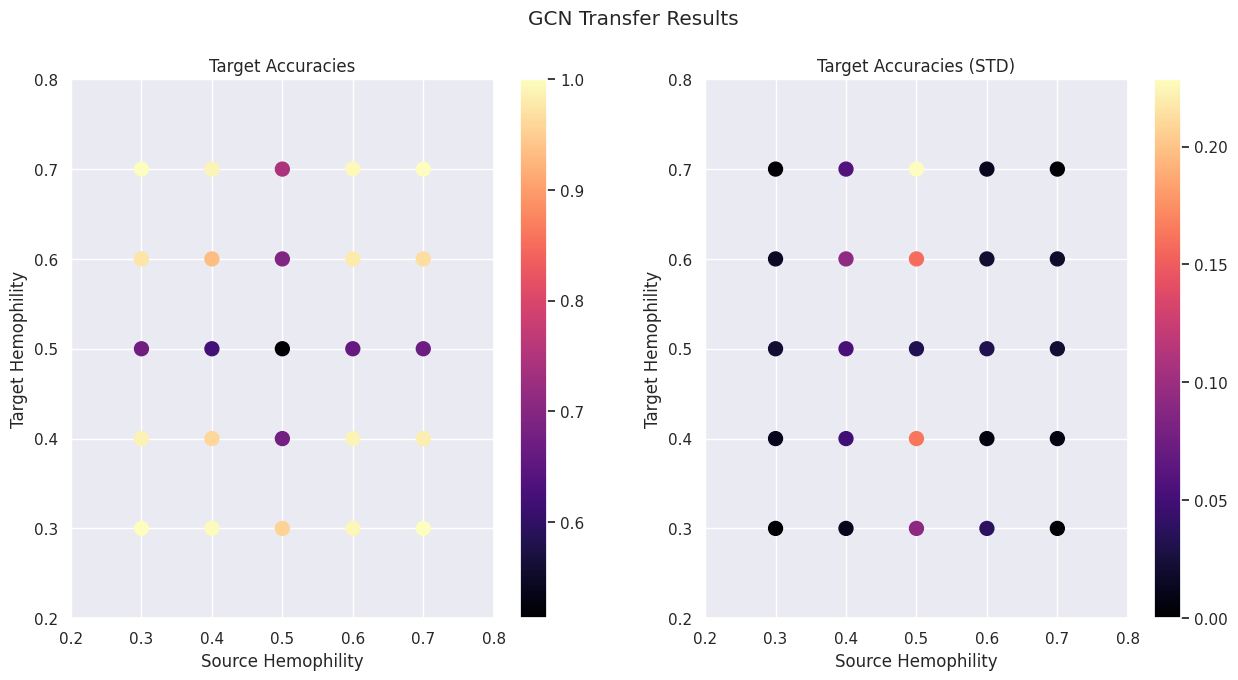

In [190]:

plt.figure(figsize = (15,7))
plt.suptitle('GCN Transfer Results')
plot_struct_sweep_histogram(results, experiments)
plt.show()

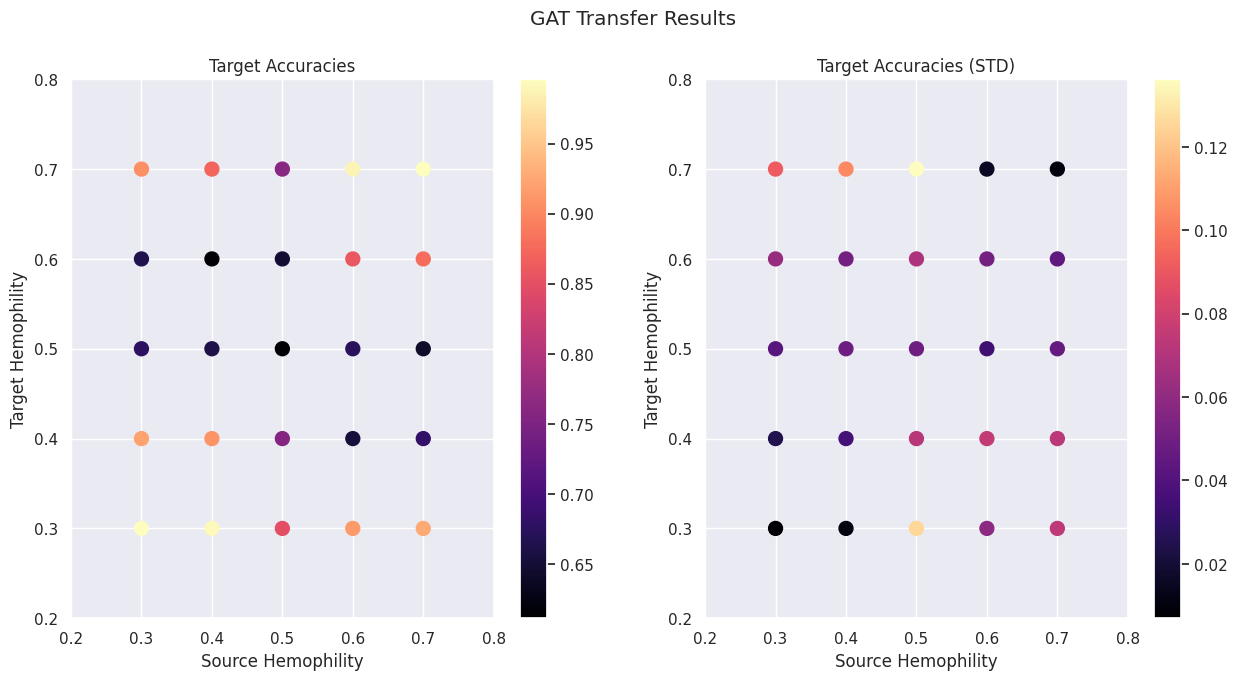

In [195]:

plt.figure(figsize = (15,7))
plt.suptitle('GAT Transfer Results')
plot_struct_sweep_histogram(results, experiments)
plt.show()

## Basic Transfer

### GCN

In [ ]:
model = 'GCN'

print(f'{model} Transfer Results\n')
for exp_ind in range(n_experiments):
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, std = {np.sqrt(src_accs.var()):.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, std = {np.sqrt(tgt_accs.var()):.4f}')
  print("\n\n\n")


GCN Transfer Results



Hemophilic - No Structure Shift

Source Accuracy: mean = 0.9995, variance = 0.0000

Target Accuracy: mean = 0.9168, variance = 0.0201









Heterophilic - No Structure Shift

Source Accuracy: mean = 0.9992, variance = 0.0000

Target Accuracy: mean = 0.9015, variance = 0.0229









Hemophilic to Heterophilic Structure Shift

Source Accuracy: mean = 0.9993, variance = 0.0000

Target Accuracy: mean = 0.9440, variance = 0.0145









Heterophilic to Homophilic Structure Shift

Source Accuracy: mean = 0.9987, variance = 0.0000

Target Accuracy: mean = 0.9027, variance = 0.0274










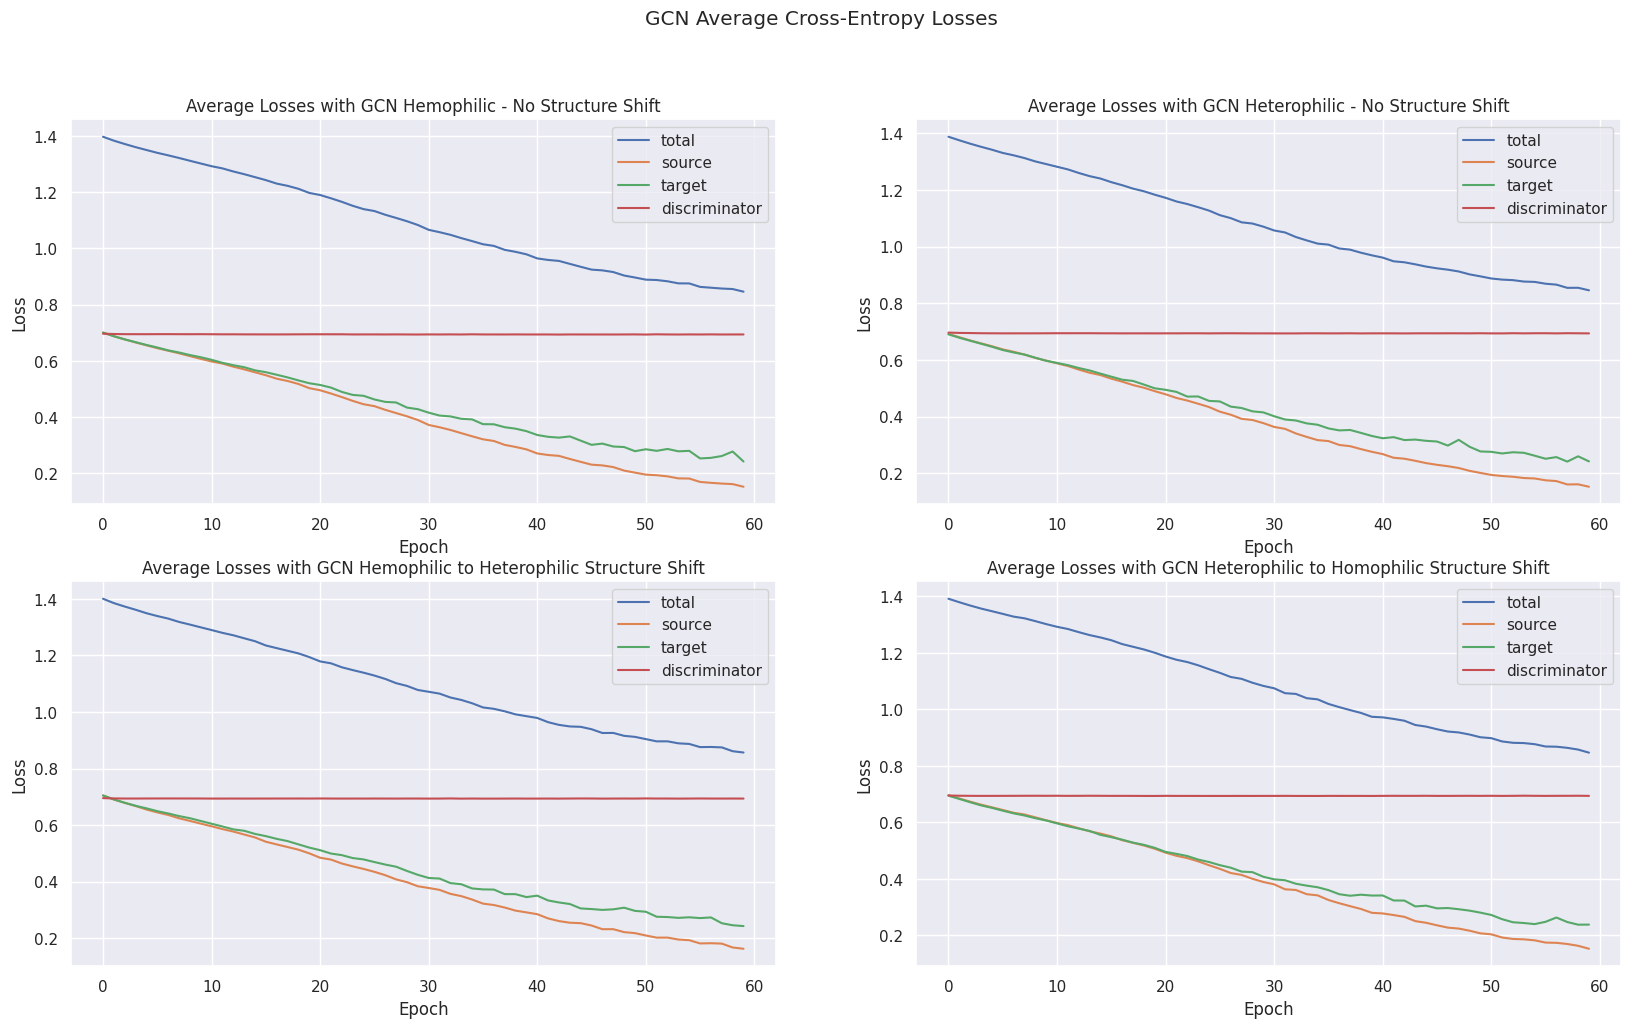

In [ ]:
import matplotlib.pyplot as plt

model = 'GCN'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['total', 'source', 'target', 'discriminator']




for exp_ind in range(n_experiments):
  plt.subplot(2,2, exp_ind + 1)

  key = experiments[exp_ind]
  plot_losses(results[key]['avg_losses'], title=f'Average Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()

### GAT

In [ ]:
model = 'GAT'

print(f'{model} Transfer Results\n')
for exp_ind in range(n_experiments):
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, std = {np.sqrt(src_accs.var()):.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, std = {np.sqrt(tgt_accs.var()):.4f}')
  print("\n\n\n")


GAT Transfer Results



Hemophilic - No Structure Shift

Source Accuracy: mean = 0.9288, variance = 0.0221

Target Accuracy: mean = 0.9087, variance = 0.0307









Heterophilic - No Structure Shift

Source Accuracy: mean = 0.9148, variance = 0.0241

Target Accuracy: mean = 0.8808, variance = 0.0373









Hemophilic to Heterophilic Structure Shift

Source Accuracy: mean = 0.9483, variance = 0.0136

Target Accuracy: mean = 0.5568, variance = 0.0173









Heterophilic to Homophilic Structure Shift

Source Accuracy: mean = 0.9312, variance = 0.0286

Target Accuracy: mean = 0.6035, variance = 0.0315










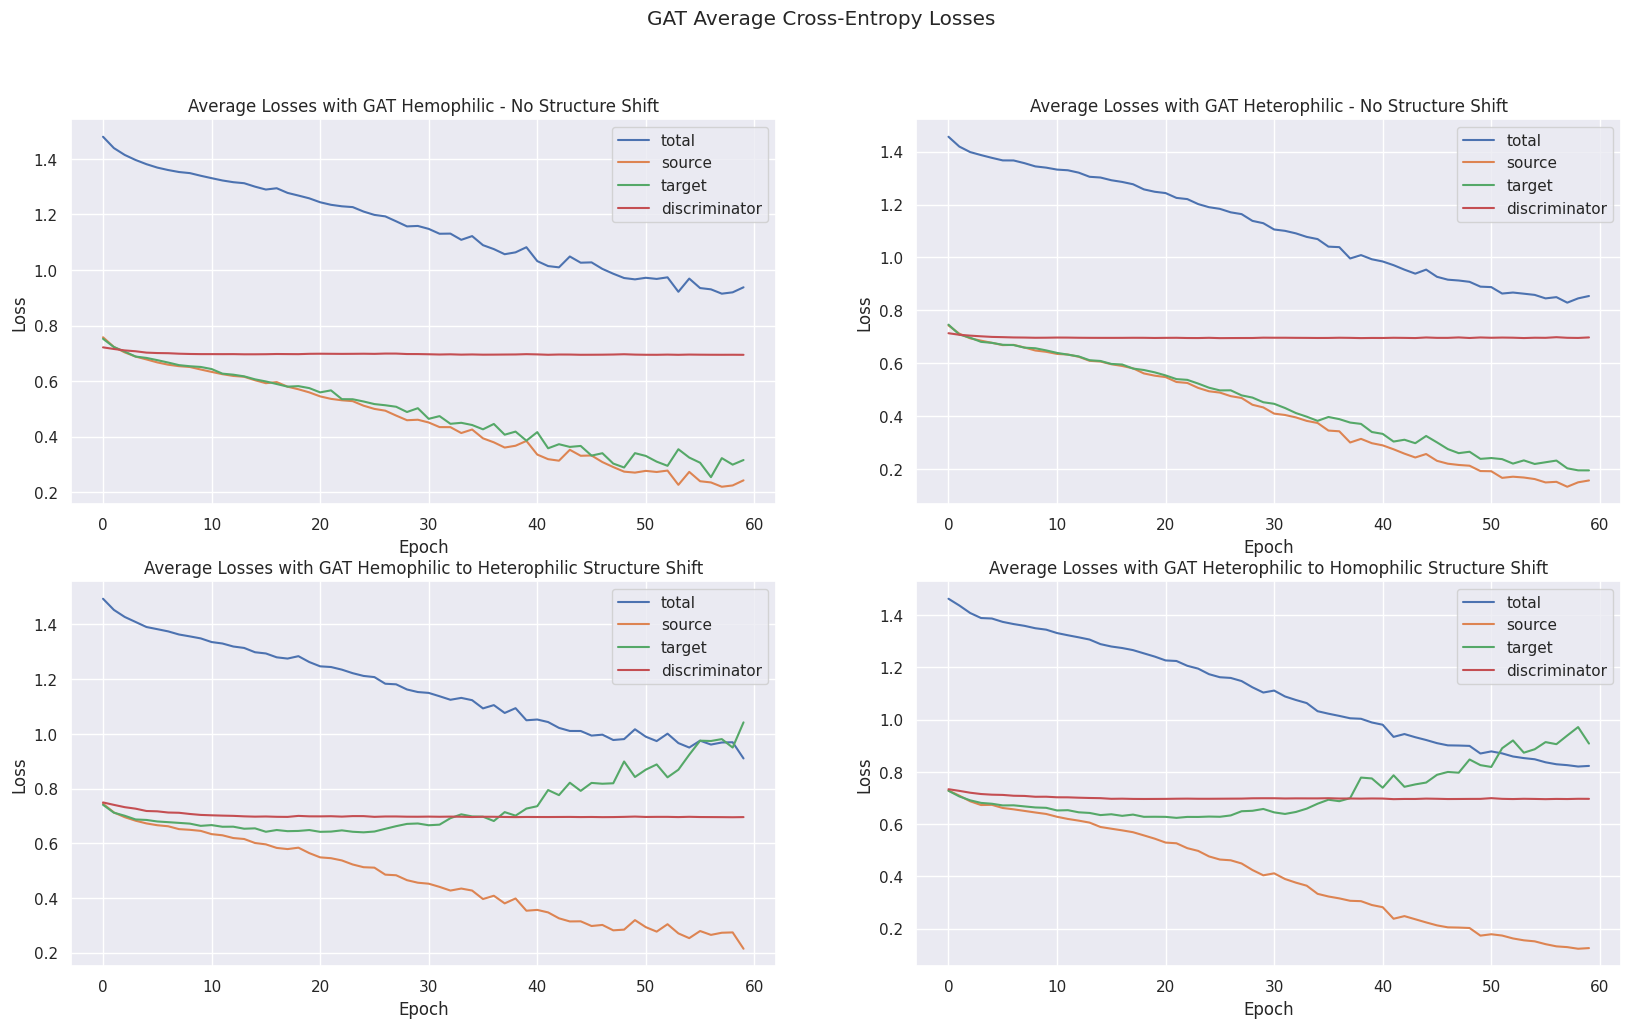

In [ ]:
import matplotlib.pyplot as plt

model = 'GAT'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['total', 'source', 'target', 'discriminator']




for exp_ind in range(n_experiments):
  plt.subplot(2,2, exp_ind + 1)

  key = experiments[exp_ind]
  plot_losses(results[key]['avg_losses'], title=f'Average Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)

plt.show()

## Source Structure Effect

### GCN

In [ ]:
model = 'GCN'

print(f'{model} Transfer Results')
for exp_ind in range(n_experiments):
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, std = {np.sqrt(src_accs.var()):.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, std = {np.sqrt(tgt_accs.var()):.4f}')
  print("\n\n")


GCN Transfer Results











Structure 1

Source Accuracy: mean = 1.0000, variance = 0.0000

Target Accuracy: mean = 0.9733, variance = 0.0097







Structure 2

Source Accuracy: mean = 0.9882, variance = 0.0006

Target Accuracy: mean = 0.9738, variance = 0.0057







Structure 3

Source Accuracy: mean = 0.6848, variance = 0.0044

Target Accuracy: mean = 0.8822, variance = 0.0340







Structure 4

Source Accuracy: mean = 0.9865, variance = 0.0004

Target Accuracy: mean = 0.9610, variance = 0.0105







Structure 5

Source Accuracy: mean = 1.0000, variance = 0.0000

Target Accuracy: mean = 0.9965, variance = 0.0001















Structure 1

Source Accuracy: mean = 0.9997, variance = 0.0000

Target Accuracy: mean = 0.9665, variance = 0.0079







Structure 2

Source Accuracy: mean = 0.9903, variance = 0.0002

Target Accuracy: mean = 0.9725, variance = 0.0082







Structure 3

Source Accuracy: mean = 0.6440, variance = 0.0052

Target Accuracy: mean = 0.9403, variance = 0.0166

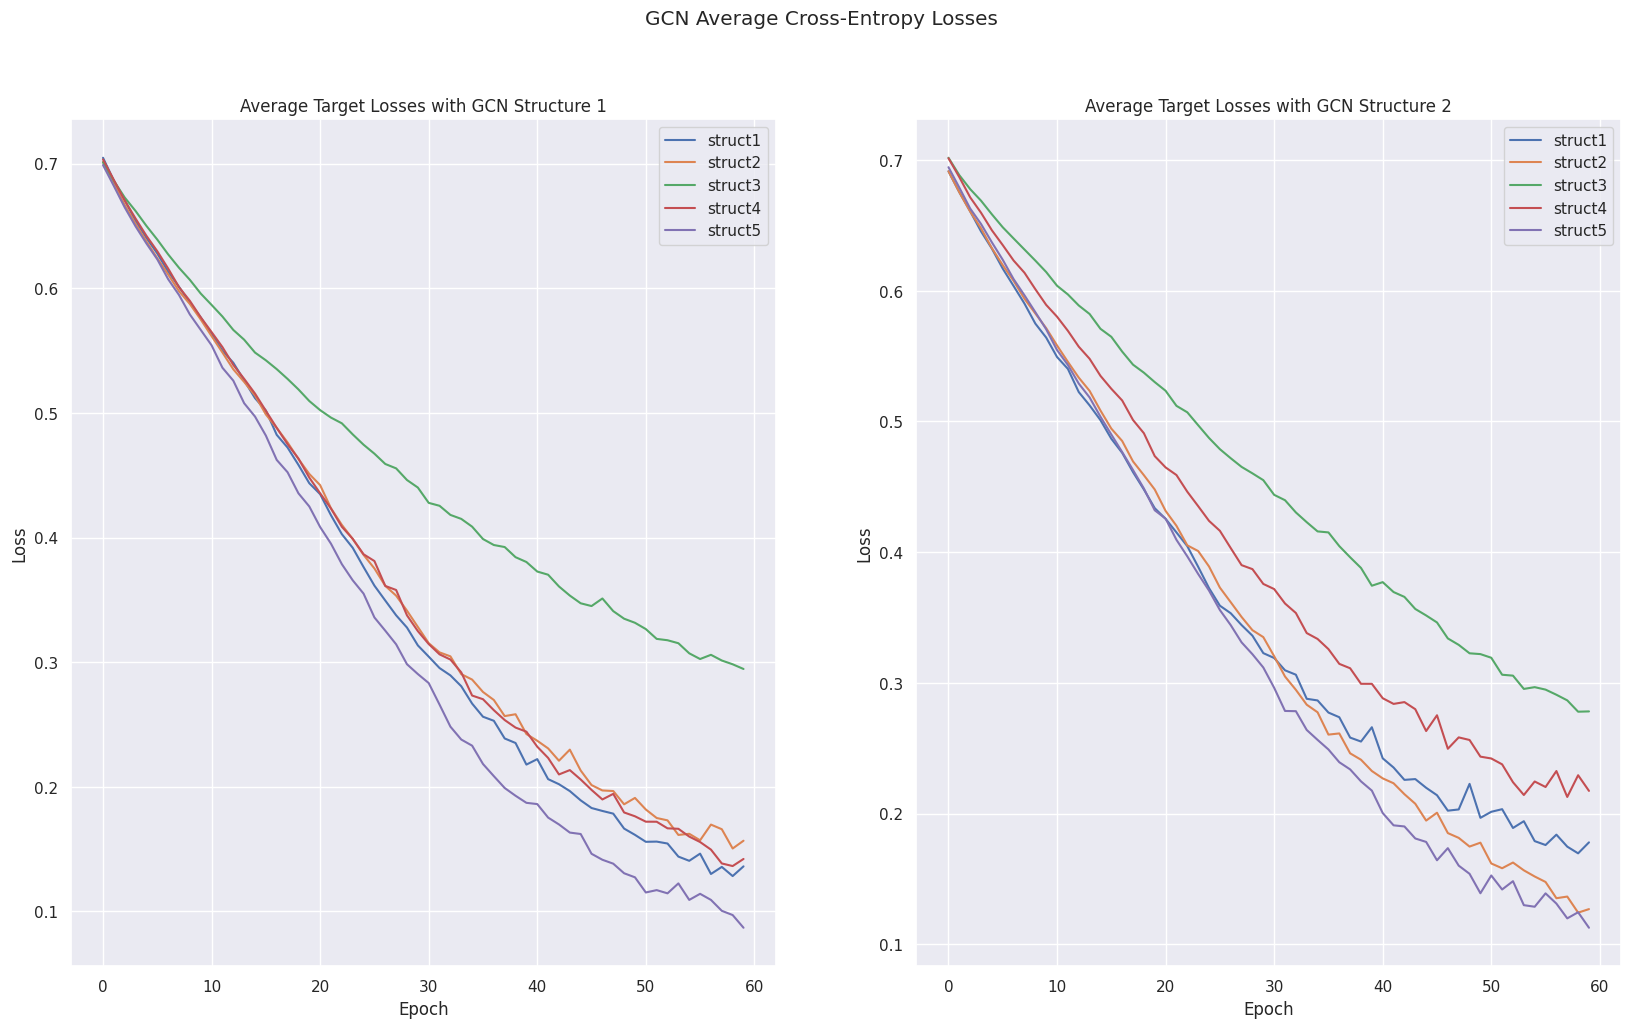

In [ ]:
import matplotlib.pyplot as plt

model = 'GCN'

plt.figure(figsize=(20,11))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = ['struct1', 'struct2', 'struct3', 'struct4', 'struct5']



# create test dictionary
target_losses = [dict(), dict(), dict()]

for i in range(3):

  for key in avg_losses_keys:
    target_losses[i][key] = all_results[i][key]['avg_losses']['target']


for exp_ind in range(n_target_probs):
  plt.subplot(1,3, exp_ind + 1)

  plot_losses(target_losses[exp_ind], title=f'Average Target Losses with {model} {experiments_descriptions[exp_ind]}', keys = avg_losses_keys)



plt.show()

### GAT

In [ ]:
model = 'GAT'

print(f'{model} Transfer Results\n')
accs = dict()


for exp_ind in range(n_experiments):

  for tgt_exp_ind =
  experiment_key = experiments[exp_ind]
  experiment_description = experiments_descriptions[exp_ind]
  src_accs = results[experiment_key]['src_accs']
  tgt_accs = results[experiment_key]['tgt_accs']

  print(experiment_description)
  print(f'Source Accuracy: mean = {src_accs.mean():.4f}, std = {np.sqrt(src_accs.var()):.4f}')
  print(f'Target Accuracy: mean = {tgt_accs.mean():.4f}, std = {np.sqrt(tgt_accs.var()):.4f}')
  print("\n\n\n")


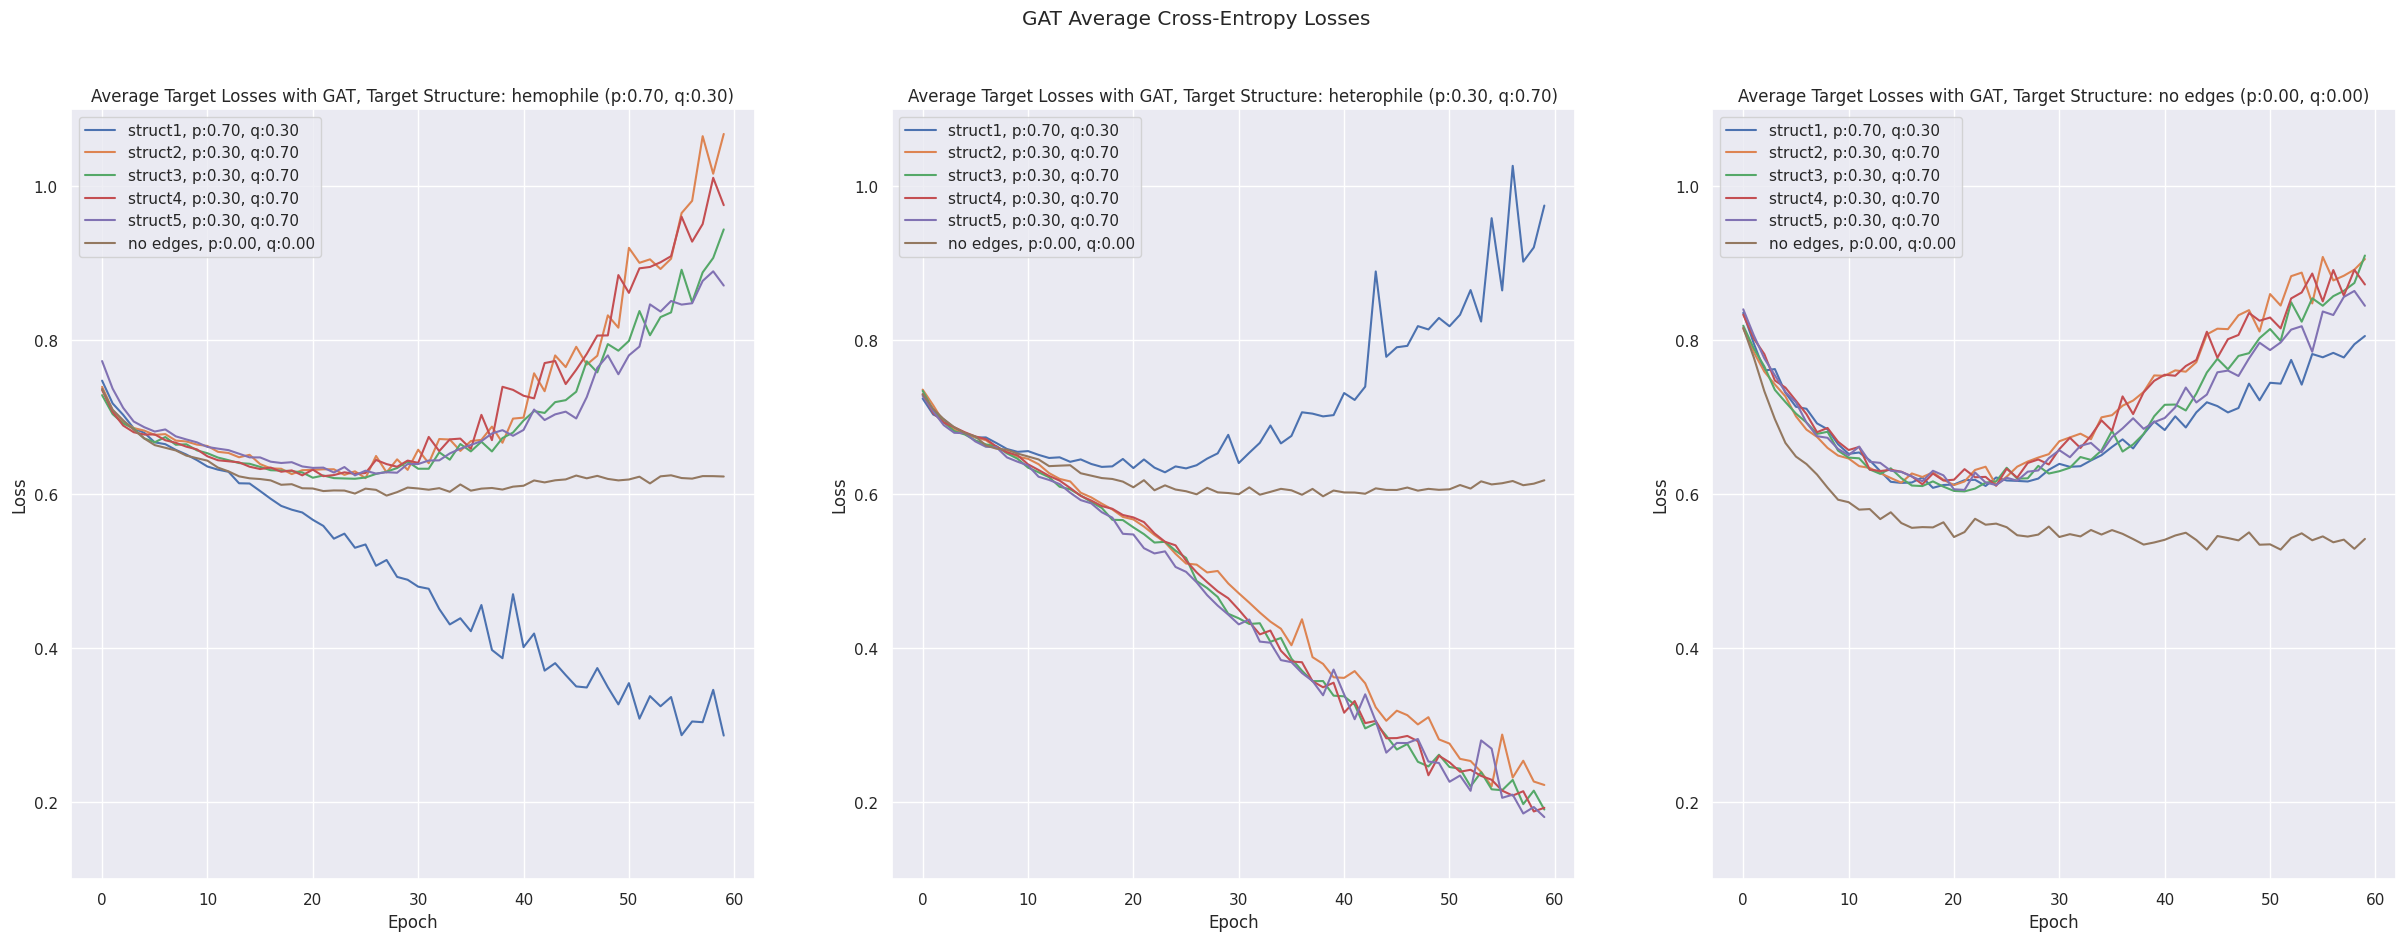

In [41]:
import matplotlib.pyplot as plt

model = 'GAT'

plt.figure(figsize=(30,10))
plt.suptitle(f'{model} Average Cross-Entropy Losses')

avg_losses_keys = experiments



# create test dictionary

n_target_probs = 3
target_losses = []
target_descriptions = ['hemophile', 'heterophile', 'no edges']


plot_keys = []
for i in range(n_target_probs):
  target_losses.append(dict())
  for loss_ind in range(len(avg_losses_keys)):
    plot_key = avg_losses_keys[loss_ind] + f', p:{experiments_source_probs[loss_ind][0]:.2f}, q:{experiments_source_probs[loss_ind][1]:.2f}'
    plot_keys.append(plot_key)
    target_losses[i][plot_key] = all_results[i][avg_losses_keys[loss_ind]]['avg_losses']['target']


for exp_ind in range(n_target_probs):
  plt.subplot(1,3, exp_ind + 1)
  title = f'Average Target Losses with {model}, Target Structure: {target_descriptions[exp_ind]} (p:{experiments_target_probs[exp_ind][0]:.2f}, q:{experiments_target_probs[exp_ind][1]:.2f})'
  plot_losses(target_losses[exp_ind],
              title= title,
              legends = plot_keys)
  plt.ylim((0.1,1.1))

plt.show()